# Notebook 6: Representation challenge in ML
This notebook consist of two parts. The first part contains an example of a Machine Learning Force Field (MLFF) on a $C_{60}$ buckyball molecule. The second part contains a starting exercise for of the 5EC project.

# Part 1: Learning the potential energy surface of a thermally distorted buckyball 

We want to capture the **state** of the system by an efficient set of features. Preferably, the state should be unique. In this way one input state can be linked to only one label.

We will now consider the case of a single buckyball molecule. The coordinates of the atomic nuclei describe the structural arrangement $\{\mathbf{R}^{(m)}_i\}$ and total potential energy $(U_m)$ of the molecule as a whole. 

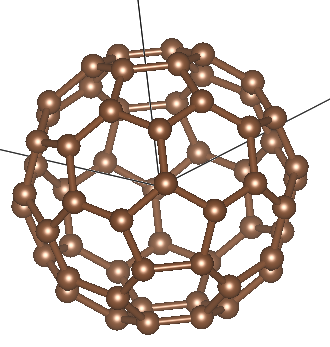

In [2]:
# importing the required modules
##%pip install numpy matplotlib scikit-learn pandas #installs them if they are not yet there
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

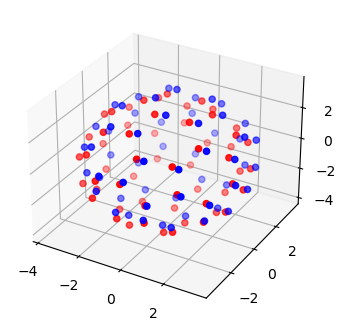

In [3]:
# Load the structural and energy database for the buckyballs
Msample=25
coords_data_tmp=(np.loadtxt('bucky-coords_database.txt'))
coords_data=np.zeros((60,3,Msample))
for i in range(Msample):
    coords_data[:,:,i]=coords_data_tmp[i*60:(i+1)*60,0:3]

energy_data=np.loadtxt('bucky-energies_database.txt')
energy_data=energy_data.reshape((Msample,1))

# Plot the first and last structure in the database
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(coords_data[:,0,0],coords_data[:,1,0],coords_data[:,2,0],c='b', marker='o')
ax.scatter(coords_data[:,0,Msample-1],coords_data[:,1,Msample-1],coords_data[:,2,Msample-1],c='r', marker='o')


## ML model of the potential energy surface
We now want to use ML to learn the map from coordinates to potential energy $F_{ML}[\mathbf{R_1},\cdots,\mathbf{R}_{60}]$, however Cartesian coordinates are not very suitable. Given a set of Cartesian coordinates of molecule m ($\{\mathbf{R}^{(m)}_i\}$) we can translate and rotate the molecule in space without changing its potential energy. This means that there are **infinitely** many Cartesian state representations for exactly the same molecule.

**Minimal solution to be implemented:**
1. Represent each atom in the molecule by the three distances to the nearest neighboring atoms $[d_{nn1},d_{nn2},d_{nn3}]$. This does not reduce the dimensionality of our representation, ie. coords[60,3] to new_coords[60,3], but in this representation the molecule is **invariant to translation and rotation**. This representation is called a **descriptor**. _Does it matter how you order the distances, ie. $[d_{nn2},d_{nn3},d_{nn1}]$ or any other permutation?_
2. We furthermore assume that the potential energy of the whole molecule can be descomposed into local atomic energies: $U^{(m)}=\sum_{i=1}^{60}U_i=\sum_{i=1}^{60}F_{ML}[d_{nn1},d_{nn2},d_{nn3}]$.
3. Build a ML model that maps the descriptor to the energy label. This can be a regression model or a small neural network, you choose, you set it up and make it work.

**Optional improvements:**
You might not be satisfied with the RMS error that your ML model scores on the training set. That is to be expected as you have thrown a lot of information about the buckyball out of the window by respesnting it only by its nearest neighbor distances. These improvemets might improve the accuracy of your model and could imporve the predictions your make on the test set.

4. Extend the representation of the atoms with the angles that it makes with the nearest neighboring atoms $[d_{nn1},d_{nn2},d_{nn3}, \theta_1, \theta_2, \theta_3]$.
5. Extend the representation to the second nearest neighboring atoms.



In [4]:
# Helper routine, use if you find it usefull.
# Sets up a nearest neighbor table in which you find all atoms within a distance < 1.5 Angstrom.
# nn (i: atom index , j : index of the neigbouring atom , (0): index number of neigbour (1) distance to that neighbor )
def nntable(coords,maxnn=3,cutoff=1.5):
    N=coords.shape[0]
    nn=np.zeros((N,maxnn,2))
    cnt=0
    maxcnt=0
    for i in range(0,N):
        for j in range(0,N):
            if i!=j: 
                dist=np.linalg.norm(coords[i,:]-coords[j,:])
                if dist<cutoff:
                    nn[i,cnt,0]=j
                    nn[i,cnt,1]=dist
                    cnt=cnt+1
                    if cnt>maxcnt:
                        maxcnt=cnt
        cnt=0
    #print(maxcnt)    
    return(nn)

have_a_look_at_this=nntable(coords_data[:,:,0],maxnn=3,cutoff=1.6)
print(have_a_look_at_this)

[[[ 6.          1.39244466]
  [12.          1.45123803]
  [24.          1.45230638]]

 [[ 7.          1.36615309]
  [13.          1.51125266]
  [25.          1.45640395]]

 [[ 8.          1.43478217]
  [14.          1.45224607]
  [26.          1.41575545]]

 [[ 9.          1.3858079 ]
  [15.          1.45429765]
  [27.          1.52996594]]

 [[10.          1.38206367]
  [16.          1.53533958]
  [28.          1.44503589]]

 [[11.          1.41603462]
  [17.          1.48909943]
  [29.          1.45184682]]

 [[ 0.          1.39244466]
  [18.          1.44196031]
  [36.          1.48377996]]

 [[ 1.          1.36615309]
  [19.          1.48196785]
  [37.          1.49482179]]

 [[ 2.          1.43478217]
  [20.          1.49735423]
  [38.          1.48327211]]

 [[ 3.          1.3858079 ]
  [21.          1.42827037]
  [39.          1.51645325]]

 [[ 4.          1.38206367]
  [22.          1.47038561]
  [40.          1.44646604]]

 [[ 5.          1.41603462]
  [23.          1.47183854

In [5]:
# 1. Build the descriptor. Your function should read in all coordinates of one molecule coord[60,3] and give back a descriptor [60,3] with the distances to the closest nearest neighbors.
# nn (i: atom index , j : index of the neigbouring atom , (0): index number of neigbour (1) distance to that neighbor )

def descriptor(coords, nn = nntable(coords_data[:,:,0],maxnn=3,cutoff=1.6), maxnn=3):

    """calculate the distances between each atom and its three nearest neighbors"""
    N=coords.shape[0]
    desc = np.zeros((N, maxnn))
    for i in range(N):
        for j in range(maxnn):
            desc[i,j] = np.linalg.norm(coords[i,:]-coords[int(nn[i,j,0]),:])
    
    desc = np.sort(desc, axis = 1)
    
    return(desc)

maxnn = 3
descriptor(coords_data[:,:,2])



array([[1.39981821, 1.44203618, 1.46988772],
       [1.35755807, 1.40206182, 1.48124274],
       [1.40875419, 1.42254319, 1.48376773],
       [1.39882491, 1.44419413, 1.44468846],
       [1.37657571, 1.40236991, 1.45869348],
       [1.38699949, 1.41493541, 1.44781176],
       [1.39981821, 1.44728645, 1.45579949],
       [1.35755807, 1.42633938, 1.46373866],
       [1.40875419, 1.41172679, 1.44903021],
       [1.39882491, 1.42106672, 1.45252303],
       [1.40236991, 1.40242438, 1.43674596],
       [1.38699949, 1.45484609, 1.47196016],
       [1.41576559, 1.44203618, 1.45847303],
       [1.39601503, 1.40206182, 1.41727273],
       [1.41783324, 1.42254319, 1.42559029],
       [1.41468975, 1.41884628, 1.44419413],
       [1.37657571, 1.39119904, 1.48003545],
       [1.41493541, 1.42329835, 1.44957585],
       [1.35350178, 1.44242219, 1.45579949],
       [1.39380823, 1.45102239, 1.46373866],
       [1.38192444, 1.41172679, 1.49765996],
       [1.41967432, 1.45252303, 1.45976794],
       [1.

In [6]:
# 2 & 3 Build your ML model to learn the potential energy of a buckyball based on its atomic coordinates.
# You can build a Rgression model or a NN. Do not forget to feature scale!

print(coords_data.shape)
print(energy_data.shape)
    
# def compute_descriptors(coords_data, Msample):
#     descriptors = []
#     for i in range(Msample):
#         descriptors.append(descriptor(coords_data[:,:,i]))
#     return descriptors

# #print(coords_data)

# descriptors = compute_descriptors(coords_data, Msample)
# print(descriptors)

(60, 3, 25)
(25, 1)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

def coords_to_X(coords, Msample, maxnn):
    X = np.zeros((Msample, maxnn))
    for i in range(Msample):
        X[i, :] = np.sum(descriptor(coords[:,:,i]), axis = 0)
    
    return X
    
X = coords_to_X(coords_data, Msample, maxnn)
y = energy_data

print("X",X.shape,"Y",y.shape)
#print(X)

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)
polyX = PolynomialFeatures(2, include_bias=False).fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
polyX_scaled = scaler.fit_transform(polyX)

print(X_train_scaled)
print(polyX_scaled)

X (25, 3) Y (25, 1)
[[ 0.50011129 -0.11363512 -0.5784382 ]
 [-0.64183703  1.55339502  0.7323535 ]
 [-1.6759583  -1.62520233  0.5386853 ]
 [ 0.03388083  0.13402917 -0.47243832]
 [-0.98921789  2.25178063 -0.14288287]
 [-0.60935327 -0.38217682  0.0098482 ]
 [ 0.56267264 -1.79684374 -0.94383104]
 [-0.72504853 -1.48604643 -1.31445805]
 [-0.92671726 -0.79801347  0.40975518]
 [ 0.69452311 -0.68620963 -1.61512846]
 [ 0.10710215 -0.1637715   0.00705577]
 [ 2.15960322  1.52422867 -0.72264091]
 [-0.63648662  0.86157554  1.27557028]
 [ 1.28169035  0.22961902  0.31791944]
 [-0.3845231   0.68541317  1.46070833]
 [-0.09191062  0.06391693  0.55904095]
 [ 0.89296604  0.43499585 -1.0485934 ]
 [ 1.18954588  0.35287292  0.79079835]
 [-1.15441769  0.3103258   2.16895804]
 [ 1.52636586  0.11444478 -0.32345883]
 [-1.45673442 -0.59320973  0.74072393]
 [ 0.34374337 -0.87148874 -1.84954718]]
[[ 0.50011129 -0.11363512 -0.5784382   0.49887927  0.29204727  0.03468499
  -0.11470483 -0.42545618 -0.57912803]
 [-0.641

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

reg = LinearRegression() 
reg.fit(X_train_scaled, y_train)

poly = Ridge(alpha=0.0001)
#poly = LinearRegression()
poly.fit(polyX_scaled, y_train)

Ridge(alpha=0.0001)

## Analyse the accuracy of your ML model on the training set

RMSerror: 0.03828445018492341


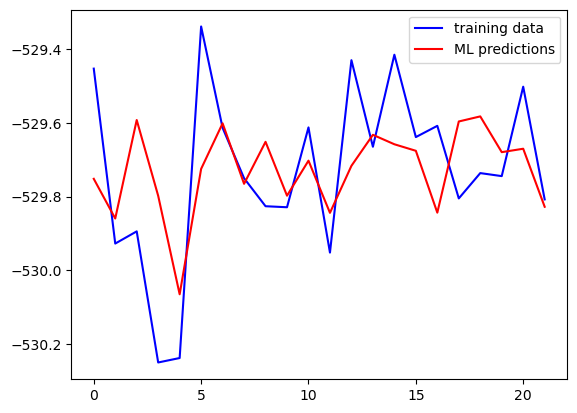

In [9]:
ypred = reg.predict(X_train_scaled)
error=ypred-y_train
rmserror=np.linalg.norm(error)*(1/Msample)
print('RMSerror:',rmserror)
plt.plot(y_train,color='b',label='training data')
plt.plot(ypred,color='r',label='ML predictions')
plt.legend()


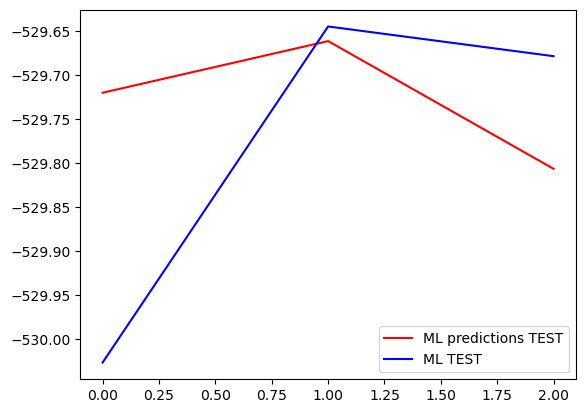

In [10]:
ypred= reg.predict(X_test_scaled)

plt.plot(ypred,color='r',label='ML predictions TEST')
plt.plot(y_test,color='b',label='ML TEST')
plt.legend()

RMSerror: 0.03677063779702726


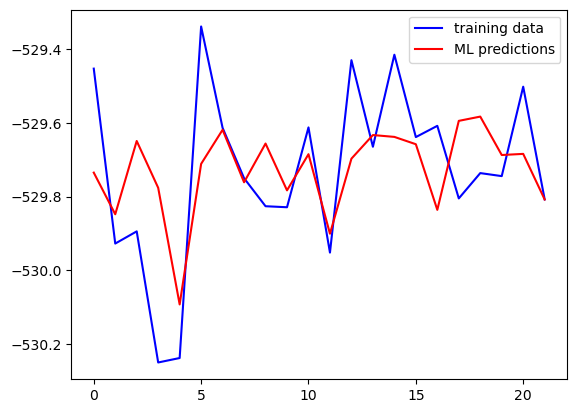

In [11]:
ypred = poly.predict(polyX_scaled)
error=ypred-y_train
rmserror=np.linalg.norm(error)*(1/Msample)
print('RMSerror:',rmserror)
plt.plot(y_train,color='b',label='training data')
plt.plot(ypred,color='r',label='ML predictions')
plt.legend()

## Use your ML model to predict energies on the test set

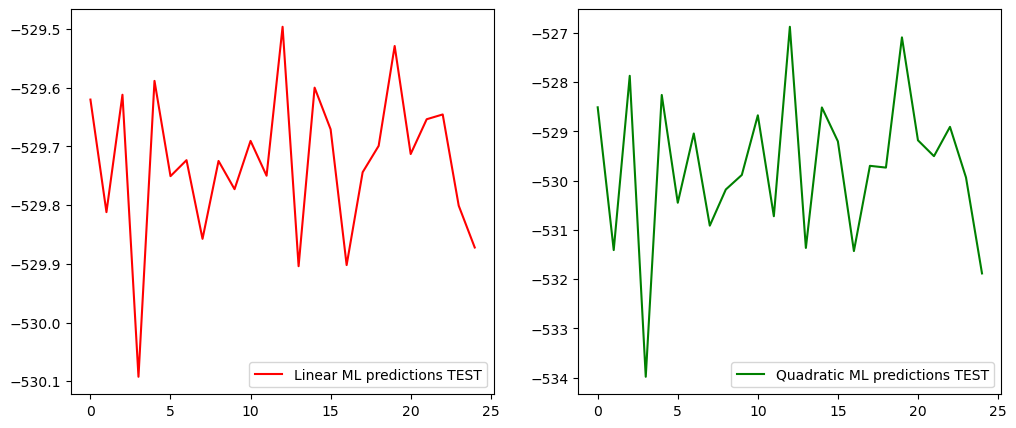

In [12]:
# Load the TEST structural database for the buckyballs   
Msample=25
coords_data_tmp=np.loadtxt('TESTbucky-coords_database.txt')
coords_data_test=np.zeros((60,3,Msample))
for i in range(Msample):
    coords_data_test[:,:,i]=coords_data_tmp[i*60:(i+1)*60,0:3]
    
X_test2 = coords_to_X(coords_data_test, Msample, maxnn)
X_test2_scaled = scaler.fit_transform(X_test2)
polyX_test2 = PolynomialFeatures(2, include_bias=False).fit_transform(X_test2)
polyX_test2_scaled = scaler.fit_transform(polyX_test2)

#print(X_test2.shape)
ypred = reg.predict(X_test2_scaled)
ypred_poly = poly.predict(polyX_test2_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ypred,color='r',label='Linear ML predictions TEST')
ax[1].plot(ypred_poly,color='g',label='Quadratic ML predictions TEST')
ax[0].legend()
ax[1].legend()

np.savetxt('PREDICTIONS-energies_TEST.txt', ypred_poly)

Let's extend the representation of the atoms with the angles.

In [13]:
def angle(v1, v2):
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

def calculate_angles(coords, nn = nntable(coords_data[:,:,0],maxnn=3,cutoff=1.6), maxnn=3):
    N=coords.shape[0]
    desc = np.zeros((N, maxnn))
    for i in range(N):
        v1, v2, v3 = [coords[i,:]-coords[int(nn[i,j,0]),:] for j in range(maxnn)]
        desc[i,:] = [angle(v1, v2), angle(v1, v3), angle(v2, v3)]
    
    desc = np.sort(desc, axis = 1)
    return desc

calculate_angles(coords_data[:,:,0])


array([[1.91330567, 2.07215416, 2.0944301 ],
       [1.86824037, 2.08091033, 2.11760305],
       [1.91209885, 2.03956615, 2.10491743],
       [1.87164501, 2.09639895, 2.1102234 ],
       [1.87163869, 2.03891908, 2.16251796],
       [1.88604418, 2.07220758, 2.10454229],
       [1.88706219, 2.07930167, 2.14561489],
       [1.83926112, 2.09598158, 2.10623524],
       [1.83591228, 2.05606955, 2.07525063],
       [1.85248908, 2.06865317, 2.11207299],
       [1.86610003, 2.08401479, 2.12998689],
       [1.87757012, 2.07020643, 2.0970577 ],
       [1.87384356, 2.06028019, 2.16395764],
       [1.86211492, 2.05312033, 2.16455705],
       [1.88423229, 2.03476447, 2.07663207],
       [1.88767322, 2.10922647, 2.12944032],
       [1.86311044, 2.10614535, 2.10770674],
       [1.8696652 , 2.09599822, 2.13658689],
       [1.90877731, 2.04695492, 2.0874128 ],
       [1.92816833, 2.03141906, 2.09583464],
       [1.89157666, 2.02523143, 2.11033491],
       [1.9341497 , 2.03693665, 2.09528454],
       [1.

In [14]:
X_angles = np.zeros((Msample, maxnn))
for i in range(Msample):
    X_angles[i, :] = np.sum(calculate_angles(coords_data[:,:,i]), axis = 0)

X = np.hstack((coords_to_X(coords_data, Msample, maxnn), X_angles))
y = energy_data
print("X",X.shape,"Y",y.shape)

polyX = PolynomialFeatures(2, include_bias=False).fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
polyX_scaled = scaler.fit_transform(polyX)

print(X_scaled)


X (25, 6) Y (25, 1)
[[-1.01328594  2.0041289   2.1791587   1.70051813 -0.53434833  0.63660152]
 [-0.99901011  2.06849773 -0.16410865  0.48929451  1.03032699 -0.85961918]
 [-0.72671024 -1.51710136 -1.21138155 -0.86169054 -1.44663479  1.51341483]
 [ 0.13105209 -0.24867783 -0.03007826 -1.39297649  1.91577799 -2.00576148]
 [ 2.24672433  1.37057628 -0.68235527  0.50132888  0.41063488 -0.39183716]
 [ 0.60064397 -1.81524105 -0.88007749 -0.00300138  1.28594249 -1.40962624]
 [ 0.37497657 -0.92757236 -1.68969858  0.57699521  0.80045929 -0.95984189]
 [ 1.2468109   0.24692555  0.67051047 -0.70157127  0.06713035  0.00933967]
 [-0.18563882  0.53176346  0.23056314  0.25436193  0.98007035 -0.87476799]
 [-1.70688678 -1.65058995  0.44514621  0.35800521  0.82421699 -0.62924521]
 [-1.16929438  0.20611122  1.9024496   0.51540671 -0.18420058  0.42828887]
 [-0.64093769  1.39855479  0.61826653 -0.59835132  0.8500695  -0.65390292]
 [-0.93458587 -0.85708946  0.32989538  0.83840129 -1.53386994  1.57805667]
 [ 0.

In [15]:
reg = LinearRegression() 
reg.fit(X_scaled, y)

poly = Ridge(alpha=0.001)
#poly = LinearRegression()
poly.fit(polyX_scaled, y)


Ridge(alpha=0.001)

RMSerror: 0.0250236106677082


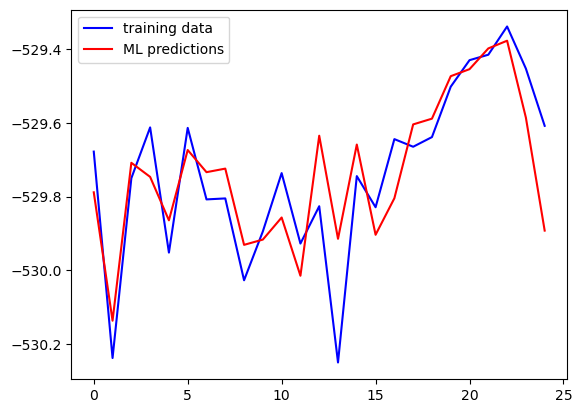

In [16]:
ypred = reg.predict(X_scaled)
error=ypred-y
rmserror=np.linalg.norm(error)*(1/Msample)
print('RMSerror:',rmserror)
plt.plot(y,color='b',label='training data')
plt.plot(ypred,color='r',label='ML predictions')
plt.legend()

RMSerror: 0.024299935459363486


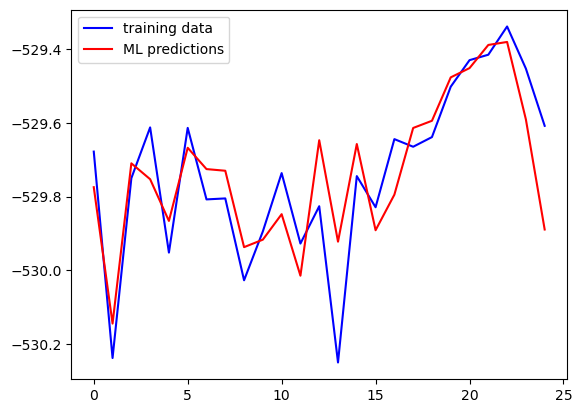

In [17]:
ypred = poly.predict(polyX_scaled)
error=ypred-y
rmserror=np.linalg.norm(error)*(1/Msample)
print('RMSerror:',rmserror)
plt.plot(y,color='b',label='training data')
plt.plot(ypred,color='r',label='ML predictions')
plt.legend()

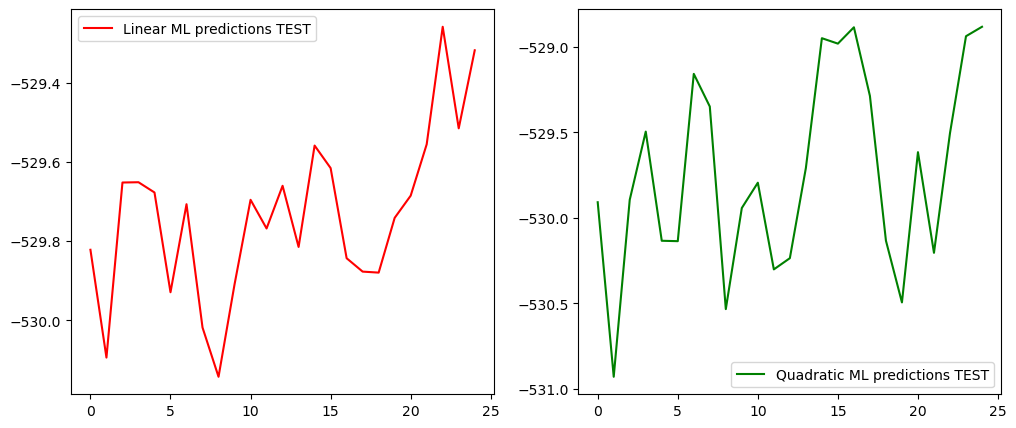

In [18]:
# Load the TEST structural database for the buckyballs   
Msample=25

X_angles = np.zeros((Msample, maxnn))
for i in range(Msample):
    X_angles[i, :] = np.sum(calculate_angles(coords_data_test[:,:,i]), axis = 0)

X_test2 = np.hstack((coords_to_X(coords_data_test, Msample, maxnn), X_angles))    
X_test2_scaled = scaler.fit_transform(X_test2)
polyX_test2 = PolynomialFeatures(2, include_bias=False).fit_transform(X_test2)
polyX_test2_scaled = scaler.fit_transform(polyX_test2)

#print(X_test2.shape)
ypred = reg.predict(X_test2_scaled)
ypred_poly = poly.predict(polyX_test2_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ypred,color='r',label='Linear ML predictions TEST')
ax[1].plot(ypred_poly,color='g',label='Quadratic ML predictions TEST')
ax[0].legend()
ax[1].legend()

np.savetxt('PREDICTIONS-energies_TEST.txt', ypred_poly)

# Part 2: Representation of the game broad in DiceWars 

In the final assignment of this year you have to describe the **state** of the DiceWars game board. In this last part of the representation notebook we will make a start with the project, by thinking about the state of the game board. Just as in the example of the buckyball simply making a list of all 'coordinates' is not a good idea. Consider the following changes to the board:
* A reshuffling of the colors of the opponents
* A reshape of all countries but the list of connecting countries remains unchanged
* A rotation of the entire game board

These are examples for which the state of the **global** game board does not change. How about these **local** changes:
* On one country, one dice is added
* On one country, the color is flipped
* ...

These small changes affect the global state slightly, but **locally** can have drastic consequences. Image that these changes occur at your borders.

## Assignment AB:
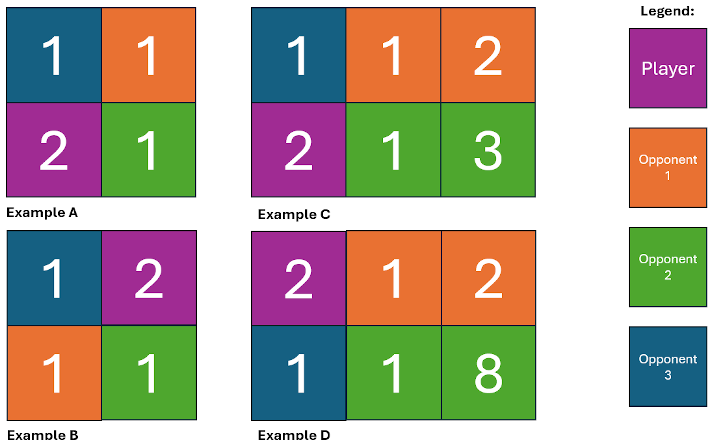

Construct a descriptor that returns the **same** state for board examples A & B.

In [35]:
#INPUT DATA EXAMPLE A
dice_A=np.ones((2,2))
dice_A[1,0]=2
players_A=np.zeros((2,2))
players_A[0,0]=1 #blue
players_A[0,1]=2 #orange
players_A[1,1]=3 #green

#INPUT DATA EXAMPLE B
dice_B=np.ones((2,2))
dice_B[0,1]=2
players_B=np.copy(players_A)
players_B[0,1]=0 #purple
players_B[1,0]=2 #orange

# Build your descriptor here

board_shape = [2,2]

def f_neighbors(position, board_shape):
    
    x, y = position
    rows, cols = board_shape
    neighbors = []

    directions = [
        (-1, 0), (1, 0), (0, -1), (0, 1),  
        (-1, -1), (-1, 1), (1, -1), (1, 1)
    ]

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < rows and 0 <= ny < cols:
            neighbors.append((nx, ny))
    
    return neighbors
    

def descriptor(dice, players, board_shape):
    
    player_id = 0
    maxp = int(np.max(players) + 1)
    my_countries = np.sum(players == player_id)
    indices = np.array(np.argwhere(players == player_id))
    #print(indices[0])
    state = np.zeros((my_countries, maxp))
    for i in range(my_countries):
        state[i,player_id] = dice[tuple(indices[i])]
        neighbors = f_neighbors(indices[i], board_shape)
        for k in neighbors:
            if players[k] != player_id:
                state[i,int(players[k])] += dice[k]
    
    state[:,1:] = np.sort(state[:, 1:], axis=1)
    return(state)

print("Descriptor A:",descriptor(dice_A,players_A, board_shape))
print("Descriptor B:",descriptor(dice_B,players_B, board_shape))


Descriptor A: [[2. 1. 1. 1.]]
Descriptor B: [[2. 1. 1. 1.]]


## Assignment CD:
Construct a descriptor that returns the **NOT same** state for board examples C & D. However, do this by presenting the board from the **viewpoint** of you, the purple player, and that **you cannot look further than the first nearest neighbors**. (Tip: it is important to know how many dice each player has in  total.)

In [ ]:
#INPUT DATA EXAMPLE C
dice_C=np.ones((2,3))
dice_C[0:1,0:1]=dice_A[0:1,0:1]     # or dice_C[0:2,0:2]=dice_A[0:2,0:2]?
dice_C[0,2]=2
dice_C[1,2]=3
players_C=np.zeros((2,3))
players_C[0:2,0:2]=players_A[0:2,0:2]
players_C[0,2]=2 #orange
players_C[1,2]=3 #green

print(players_C)
print(dice_C)


#INPUT DATA EXAMPLE B
dice_D=np.copy(dice_C)
dice_D[1,2]=8
dice_D[0,0]=2
dice_D[1,0]=1
players_D=np.copy(players_C)
players_D[0,0]=0 #purple
players_D[1,0]=1 #blue

board_shape = [2,3]

def descriptor2(dice, players, board_shape):
    
    maxp = int(np.max(players) + 1)
    
    state = descriptor(dice, players, board_shape)
    total_dices = np.zeros((1, maxp))
    for i in range(board_shape[0]):
        for j in range(board_shape[1]):
            total_dices[0, int(players[i, j])] += dice[i, j]
                 
    total_dices[:,1:] = np.sort(total_dices[:, 1:], axis=1)     #global information
    state = np.vstack((total_dices, state))
    
    
    return(state)

print("Descriptor C:",descriptor2(dice_C,players_C, board_shape))
print("Descriptor D:",descriptor2(dice_D,players_D, board_shape))

[[1. 2. 2.]
 [0. 3. 3.]]
[[1. 1. 2.]
 [1. 1. 3.]]
Descriptor C: [[1. 1. 3. 4.]
 [1. 1. 1. 1.]]
Descriptor D: [[2. 1. 3. 9.]
 [2. 1. 1. 1.]]
